# AAA Northeast Customer Clustering

## Assumptions
- We only have the current address of the customers, so we assume that most customers live in the same city most of the time.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Read data
df = pd.read_csv('./data/member_sample.csv')
df = df[~df['Member Key'].isnull()].set_index('Member Key')
df.shape
df.index

(21343, 112)

Float64Index([1500014.0, 1500014.0, 1500014.0, 1500014.0, 1500014.0, 1500014.0,
              1500014.0, 1500014.0, 1500014.0, 1500016.0,
              ...
              1532344.0, 1532345.0, 1532343.0, 3950798.0, 1532348.0, 1532348.0,
              1532348.0, 1532360.0, 1532360.0, 1532360.0],
             dtype='float64', name='Member Key', length=21343)

In [4]:
df.isnull().sum().value_counts()

0        35
7346     16
9333      8
4668      6
13166     3
7399      3
5462      3
12561     3
7390      2
7347      2
9530      2
7490      2
7601      1
7974      1
21343     1
8162      1
7432      1
7393      1
7482      1
21335     1
7358      1
7366      1
20519     1
20611     1
20702     1
20848     1
20955     1
9026      1
35        1
15960     1
10422     1
3249      1
9954      1
5453      1
11152     1
9400      1
9714      1
20483     1
17651     1
dtype: int64

## Data Preprocessing

### Column Selection
#### Identify Target Variables
- Products: 
    1. FSV CMSI
    2. FSV Credit Card
    3. FSV Deposit Program
    4. FSV Home Equity
    5. FSV ID Theft
    6. FSV Mortgage
    7. INS Client
    8. TRV Globalware
    9. New Mover
   
   
- Cost: Total Cost (Roadside data)

#### Select Key Columns
The rules of selecting columns
1. Use the granular column reasonable number of unique values when available (Ex: ZIP instead of state or ZIP9)
2. Use the more complete column within columns providing same information (Ex: gender instead of right_gender)
3. Use only one column within a group of correlated columns (Ex: Use tenure and drop Join AAA Date)information at household level.
4. Drop columns that satisfy the following criteria:
    - Have the same value on all or the majority of data (ex: Member Flag, Language)
    - Contain high missing values (ex: Reason Joined)
    - Should not be used for decision making (ex: Race)
    - Only have partial information (ex: Months from Join to Cancel is only for cancelled members)
    - Not informative (ex: Address Change Date)
    - Can't be aggregated to household level after data exploration (Ex: Education, Occupation, Vehicle)
    - Others (ex: Individual keys)
5. Keep only total cost from roadside data as the rest columns could not be aggregated

In [5]:
product_list = ['FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag', 
                'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag',
                'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag']

cost = ['Total Cost']

# selected_cols = ['Member Key', 'Household Key', 'ZIP', 'Number of Children', 
#                  'Length Of Residence', 'Mail Responder', 'Home Owner', 'Income',  
#                  'Dwelling Type', 'Credit Ranges', 'Do Not Direct Mail Solicit', 
#                  'Email Available', 'ERS ENT Count Year 1', 'ERS ENT Count Year 2', 
#                  'ERS ENT Count Year 3', 'ERS Member Cost Year 1', 'ERS Member Cost Year 2', 
#                  'ERS Member Cost Year 3', 'Member Status', 'Member Tenure Years', 'Member Type', 
#                  'Mosaic Household', 'Mosaic Global Household', 'kcl_B_IND_MosaicsGrouping']
selected_cols = ['Household Key', 'ZIP', 'Number of Children', 'Mail Responder',
                 'Length Of Residence', 'Mail Responder', 'Home Owner', 'Income',  
                 'Dwelling Type', 'Credit Ranges', 'Do Not Direct Mail Solicit', 
                 'Email Available', 'ERS ENT Count Year 1', 'ERS ENT Count Year 2', 
                 'ERS ENT Count Year 3', 'ERS Member Cost Year 1', 'ERS Member Cost Year 2', 
                 'ERS Member Cost Year 3', 'Member Status', 'Member Tenure Years', 'Member Type', 'Occupation Code', 'Occupation Group',
                 'Mosaic Household', 'Mosaic Global Household', 'kcl_B_IND_MosaicsGrouping']

### Individual Level
#### Aggregate Cost by Year
Member data is duplicated for the same individual with multiple records of roadside data. To avoid duplication, aggregate roadside data (cost) to individual level by Member Key, the unique key for member data.

In [6]:
df['Cost Year'] = pd.DatetimeIndex(pd.to_datetime(df['SC Date'], format="%Y/%m/%d %H:%M")
                                  ).year.fillna('0').astype('int64')
df['Cost Year'].unique()

array([2017, 2016, 2015,    0, 2019, 2014, 2018], dtype=int64)

In [7]:
df['Cost Year'].value_counts()

0       7346
2015    3851
2016    3551
2014    2242
2019    2151
2017    1160
2018    1042
Name: Cost Year, dtype: int64

([<matplotlib.patches.Wedge at 0x15181fbb160>,
 [Text(-0.18196294146411607, -1.2872021938816478, '0'),
  Text(1.0508965054285087, -0.3249869764746713, '2014'),
  Text(0.9097636148282543, 0.6183285252474028, '2015'),
  Text(-0.12697262115844557, 1.092647222792496, '2016'),
  Text(-0.796052207441284, 0.7591448366602115, '2017'),
  Text(-0.9963733415162971, 0.4660902963114, '2018'),
  Text(-1.0994209520162879, -0.03568711626903249, '2019')],
 [Text(-0.11197719474714833, -0.7921244270040909, '34.4%'),
  Text(0.5732162756882774, -0.17726562353163888, '10.5%'),
  Text(0.49623469899722955, 0.3372701046804015, '18.0%'),
  Text(-0.06925779335915212, 0.5959893942504523, '16.6%'),
  Text(-0.43421029496797303, 0.4140790018146608, '5.4%'),
  Text(-0.5434763680997984, 0.25423107071530904, '4.9%'),
  Text(-0.5996841556452479, -0.019465699783108626, '10.1%')])

(-1.1031931831178772,
 1.1031530786309336,
 -1.324919636046777,
 1.124896026459074)

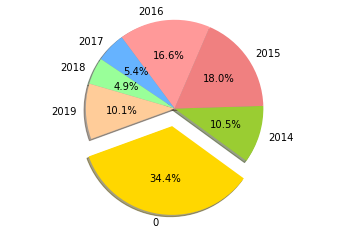

In [8]:
import matplotlib.pyplot as plt

# Data to plot
labels = 0,2014, 2015,2016,2017,2018,2019
sizes = [7346,2242,3851,3551,1160,1042,2151]
colors = ['gold', 'yellowgreen', 'lightcoral','#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=200)

plt.axis('equal')
plt.show()

In [9]:
df_cost = df[['Total Cost', 'Cost Year']
             ].reset_index().groupby(['Member Key', 'Cost Year']
                                    ).sum().reset_index().pivot(index='Member Key',
                                                                columns='Cost Year',
                                                                values='Total Cost').fillna(0)
df_cost['Total Cost'] = df_cost.sum(axis=1)
df_cost = df_cost.iloc[:,1:]
df_cost.columns = ['Cost 2014', 'Cost 2015', 'Cost 2016', 
                   'Cost 2017', 'Cost 2018', 'Cost 2019', 'Total Cost']
df_cost.head()

,Cost 2014,Cost 2015,Cost 2016,Cost 2017,Cost 2018,Cost 2019,Total Cost
Member Key,,,,,,,
115.0,0.0,29.0,0.0,0.0,0.0,0.0,29.0
116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241.0,0.0,0.0,0.0,0.0,0.0,32.5,32.5
242.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243.0,0.0,0.0,28.0,0.0,0.0,0.0,28.0


In [10]:
df_cost.shape

(12341, 7)

In [11]:
df_cost.index

Float64Index([     115.0,      116.0,      241.0,      242.0,      243.0,
                   576.0,      577.0,     2297.0,     3144.0,     3170.0,
              ...
              15906149.0, 15906285.0, 15908465.0, 15911345.0, 15911362.0,
              15914670.0, 15919250.0, 15920901.0, 15928028.0, 15929204.0],
             dtype='float64', name='Member Key', length=12341)

#### Remove Duplication

In [12]:
df.shape
df.index

(21343, 113)

Float64Index([1500014.0, 1500014.0, 1500014.0, 1500014.0, 1500014.0, 1500014.0,
              1500014.0, 1500014.0, 1500014.0, 1500016.0,
              ...
              1532344.0, 1532345.0, 1532343.0, 3950798.0, 1532348.0, 1532348.0,
              1532348.0, 1532360.0, 1532360.0, 1532360.0],
             dtype='float64', name='Member Key', length=21343)

In [13]:
df_member = df.loc[:, product_list + selected_cols
                  ].drop_duplicates().join(df_cost)
df_member.shape

(12237, 42)

In [14]:
df_member.head()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag,Household Key,...,Mosaic Household,Mosaic Global Household,kcl_B_IND_MosaicsGrouping,Cost 2014,Cost 2015,Cost 2016,Cost 2017,Cost 2018,Cost 2019,Total Cost
Member Key,,,,,,,,,,,,,,,,,,,,,
1500014.0,N,Y,N,N,N,N,N,N,N,4500791.0,...,Senior Discounts,Low Income Elders,Golden Year Guardians,0.0,83.0,124.0,97.5,0.0,0.00,304.50
1500016.0,N,N,N,N,N,N,N,N,N,4317516.0,...,Aging in Place,Comfortable Retirement,Autumn Years,0.0,0.0,0.0,0.0,0.0,0.00,0.00
1500019.0,N,N,N,N,N,N,N,N,N,11622991.0,...,No Place Like Home,Routine Service Workers,Thriving Boomers,0.0,53.0,53.0,0.0,0.0,58.85,164.85
3221131.0,N,N,N,N,N,N,N,N,N,11622991.0,...,No Place Like Home,Routine Service Workers,Thriving Boomers,0.0,0.0,0.0,0.0,0.0,0.00,0.00
4820433.0,N,N,N,N,N,N,N,N,N,11622991.0,...,No Place Like Home,Routine Service Workers,Thriving Boomers,0.0,0.0,0.0,0.0,0.0,0.00,0.00


#### Remove Cancelled members

In [15]:
df_member['Member Status'].value_counts()

CANCELLED    6273
ACTIVE       5404
PENDING       560
Name: Member Status, dtype: int64

In [16]:
df_member = df_member[df_member['Member Status'] != 'CANCELLED']

#### Transfer Data Type
- Transfer to 1 and 0: Products, Mail Responder
- Transfer to numeric than use mean: Income, Credit Ranges, Number of Children
- Create new columns: Member Type

#### 3.1 Convert Male and Female to 0 and 1

In [17]:
df_children = df_member[['Number of Children']].replace({'No children': 0,
                                                         'One Child': 1,
                                                         'Two Children': 2,
                                                         'Three Children': 3,
                                                         'Four Children': 4,
                                                         'Five Children': 5,
                                                         'Six Children': 6})
df_children.head()

,Number of Children
Member Key,
1500014.0,1.0
1500019.0,0.0
15351060.0,0.0
1500025.0,0.0
1500028.0,1.0


In [18]:
df_income = df_member[['Income']].replace({'Under 10K': 5000,
                                           '10-19,999': 15000,
                                           '20-29,999': 25000,
                                           '30-39,999': 35000,
                                           '40-49,999': 45000, 
                                           '50-59,999': 55000,
                                           '60-69,999': 65000,
                                           '70-79,999': 75000,
                                           '80-89,999': 85000,
                                           '90-99,999': 95000,
                                           '100-149,999': 125000,
                                           '150 - 174,999': 162500, 
                                           '175 - 199,999': 187500,
                                           '200 - 249,999': 225000,
                                           '250K+': 250000})
df_income.head()

,Income
Member Key,
1500014.0,35000.0
1500019.0,55000.0
15351060.0,55000.0
1500025.0,55000.0
1500028.0,125000.0


In [19]:
df_credit = df_member[['Credit Ranges']].replace({'499 & Less': 250,
                                                  '500-549': 525,
                                                  '550-599': 575,
                                                  '600-649': 625,
                                                  '650-699': 675,
                                                  '700-749': 725,
                                                  '750-799': 775,
                                                  '800+': 800,
                                                  'Unknown': np.nan
                                                 })
df_credit.head()

,Credit Ranges
Member Key,
1500014.0,625.0
1500019.0,775.0
15351060.0,775.0
1500025.0,675.0
1500028.0,675.0


In [20]:
Occup_unknown = df_member['Occupation Code'] == 'Unknown'
df_occup = pd.DataFrame({'Occupation': pd.concat([df_member['Occupation Code'][~Occup_unknown],
                                                  df_member['Occupation Group'][Occup_unknown]])})
df_occup.head()

,Occupation
Member Key,
1500014.0,NaN
1500019.0,NaN
15351060.0,NaN
1500025.0,Retired
1500028.0,NaN


In [21]:
df_member[product_list + ['Mail Responder', 'Number of Children',
                          'Income', 'Credit Ranges']].tail()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag,Mail Responder,Mail Responder,Number of Children,Income,Credit Ranges
Member Key,,,,,,,,,,,,,,
1532316.0,N,N,N,N,N,N,N,N,N,Yes,Yes,Three Children,"20-29,999",600-649
1532325.0,Y,N,N,N,N,N,N,N,N,Yes,Yes,Two Children,"100-149,999",800+
13624040.0,N,Y,N,N,N,N,N,N,N,Yes,Yes,Two Children,"100-149,999",800+
1532344.0,Y,N,N,N,N,N,Y,N,Y,Yes,Yes,Two Children,"100-149,999",600-649
1532360.0,N,N,N,N,N,N,N,N,N,Yes,Yes,Two Children,"90-99,999",650-699


In [22]:
# df_transform = df_member.drop(product_list + 
#                               ['Mail Responder', 'Number of Children', 
#                                'Income', 'Credit Ranges'],
#                               axis = 1
#                              ).join(df_occup).join(df_children).join(df_income).join(df_credit)
# df_transform.tail()

In [23]:
df_transform = df_member.drop(['Mail Responder', 'Number of Children',
                               'Income', 'Credit Ranges'],
                               axis = 1
                             ).join(df_occup).join(df_children).join(df_income).join(df_credit)
df_transform.tail()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag,Household Key,...,Cost 2015,Cost 2016,Cost 2017,Cost 2018,Cost 2019,Total Cost,Occupation,Number of Children,Income,Credit Ranges
Member Key,,,,,,,,,,,,,,,,,,,,,
1532316.0,N,N,N,N,N,N,N,N,N,45466286.0,...,0.0,0.0,0.0,0.0,0.00,0.00,Retired - Inferred,3.0,25000.0,625.0
1532325.0,Y,N,N,N,N,N,N,N,N,13735475.0,...,44.0,149.0,0.0,0.0,0.00,193.00,Management - Inferred,2.0,125000.0,800.0
13624040.0,N,Y,N,N,N,N,N,N,N,13735475.0,...,82.0,0.0,0.0,0.0,0.00,82.00,NaN,2.0,125000.0,800.0
1532344.0,Y,N,N,N,N,N,Y,N,Y,5462399.0,...,0.0,0.0,0.0,0.0,29.43,29.43,Management - Inferred,2.0,125000.0,625.0
1532360.0,N,N,N,N,N,N,N,N,N,8325571.0,...,0.0,0.0,0.0,0.0,117.70,117.70,Retired - Inferred,2.0,95000.0,675.0


In [24]:
df_transform = df_transform.assign(PrimaryMember = 
                                       [1 if x == 'Primary' else 0 
                                            for x in df_transform['Member Type']],
                                   AssociateMember = 
                                       [1 if x == 'Associate' else 0 
                                            for x in df_transform['Member Type']])
df_transform[['Member Type', 'PrimaryMember', 'AssociateMember']].tail()

,Member Type,PrimaryMember,AssociateMember
Member Key,,,
1532316.0,Primary,1,0
1532325.0,Primary,1,0
13624040.0,Associate,0,1
1532344.0,Primary,1,0
1532360.0,Primary,1,0


In [25]:
df_transform = df_transform.drop(['Member Status', 'Member Type'], axis = 1)

In [26]:
df_transform.columns

Index(['FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag',
       'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag',
       'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag',
       'Household Key', 'ZIP', 'Length Of Residence', 'Home Owner',
       'Dwelling Type', 'Do Not Direct Mail Solicit', 'Email Available',
       'ERS ENT Count Year 1', 'ERS ENT Count Year 2', 'ERS ENT Count Year 3',
       'ERS Member Cost Year 1', 'ERS Member Cost Year 2',
       'ERS Member Cost Year 3', 'Member Tenure Years', 'Occupation Code',
       'Occupation Group', 'Mosaic Household', 'Mosaic Global Household',
       'kcl_B_IND_MosaicsGrouping', 'Cost 2014', 'Cost 2015', 'Cost 2016',
       'Cost 2017', 'Cost 2018', 'Cost 2019', 'Total Cost', 'Occupation',
       'Number of Children', 'Income', 'Credit Ranges', 'PrimaryMember',
       'AssociateMember'],
      dtype='object')

### Household Level
#### Non-Numeric Columns
To aggregate non-numeric columns, we need to check if the non-numeric values within a household are too diverse. If the variables are consistent within the majority of household, we can use mode to get the variable that is representative to the household without misinterpreting the true information.

In [27]:
# Number of households with more than one values in each non-numeric columns
pd.DataFrame(df_transform.loc[:, [df_transform[x].dtype == 'O' for x in df_transform]
                             ].join(df_transform['Household Key']
                                   ).groupby(['Household Key']).nunique() > 1).sum()

FSV CMSI Flag                213
FSV Credit Card Flag         241
FSV Deposit Program Flag       7
FSV Home Equity Flag           3
FSV ID Theft Flag            105
FSV Mortgage Flag              7
INS Client Flag              459
TRV Globalware Flag          287
New Mover Flag                83
Home Owner                    23
Dwelling Type                  0
Occupation Code              489
Occupation Group             654
Mosaic Household               4
Mosaic Global Household        1
kcl_B_IND_MosaicsGrouping      4
Occupation                   670
dtype: int64

From the result we can confidently aggregate Home Owner, Dwelling Type and Mosaic columns by taking mode, because only a handful of households have more than two values in these columns.

In [28]:
categorical_cols = ['ZIP', 'Home Owner', 'Dwelling Type', 'Mosaic Household', 
                    'Mosaic Global Household', 'kcl_B_IND_MosaicsGrouping']
df_household_cat = df_transform.fillna('Not Set'
                                       ).groupby(['Household Key']
                                                )[categorical_cols].agg(lambda x: 
                                                                        x.value_counts().index[0])
df_household_cat['ZIP'] = df_household_cat['ZIP'].astype('category')
df_household_cat.head()

,ZIP,Home Owner,Dwelling Type,Mosaic Household,Mosaic Global Household,kcl_B_IND_MosaicsGrouping
Household Key,,,,,,
875.0,2921.0,Not Set,SFDU,Couples with Clout,Bourgeois Prosperity,Power Elite
969.0,2919.0,Home Owner,SFDU,Aging in Place,Comfortable Retirement,Autumn Years
8718.0,2910.0,Home Owner,SFDU,Rooted Flower Power,Post Industrial Survivors,Blue Sky Boomers
11524.0,2919.0,Home Owner,SFDU,No Place Like Home,Routine Service Workers,Thriving Boomers
13422.0,2816.0,Home Owner,SFDU,Unspoiled Splendor,Bourgeois Prosperity,Thriving Boomers


#### Numeric Columns

In [29]:
# df_household_num = df_transform.groupby(['Household Key']
#                                    ).agg({'Member Key': 'count',
#                                           'Length Of Residence': 'mean',
#                                           'Do Not Direct Mail Solicit': 'mean',
#                                           'Email Available': 'mean', 
#                                           'ERS ENT Count Year 1': ['sum', 'mean'],
#                                           'ERS ENT Count Year 2': ['sum', 'mean'],
#                                           'ERS ENT Count Year 3': ['sum', 'mean'],
#                                           'ERS Member Cost Year 1': ['sum', 'mean'],
#                                           'ERS Member Cost Year 2': ['sum', 'mean'],
#                                           'ERS Member Cost Year 3': ['sum', 'mean'],
#                                           'Member Tenure Years': 'mean',
#                                           'Cost 2014': 'sum',
#                                           'Cost 2015': 'sum',
#                                           'Cost 2016': 'sum',
#                                           'Cost 2017': 'sum',
#                                           'Cost 2018': 'sum',
#                                           'Cost 2019': 'sum',
#                                           'Total Cost': 'sum',
#                                           'Mail Responder': 'mean',
#                                           'Number of Children': 'mean',
#                                           'Income': 'mean',
#                                           'Credit Ranges': 'mean',
#                                           'AssociateMember': 'sum',
#                                           'PrimaryMember': 'sum'
#                                          })
# df_household_num.columns = [' '.join(col).strip() for col in df_household_num.columns.values]
# df_household_num.head()

In [30]:
df_household_num = df_transform.groupby(['Household Key']
                                   ).agg({'Length Of Residence': 'mean',
                                          'Do Not Direct Mail Solicit': 'mean',
                                          'Email Available': 'mean', 
                                          'ERS ENT Count Year 1': ['sum', 'mean'],
                                          'ERS ENT Count Year 2': ['sum', 'mean'],
                                          'ERS ENT Count Year 3': ['sum', 'mean'],
                                          'ERS Member Cost Year 1': ['sum', 'mean'],
                                          'ERS Member Cost Year 2': ['sum', 'mean'],
                                          'ERS Member Cost Year 3': ['sum', 'mean'],
                                          'Member Tenure Years': 'mean',
                                          'Cost 2014': 'sum',
                                          'Cost 2015': 'sum',
                                          'Cost 2016': 'sum',
                                          'Cost 2017': 'sum',
                                          'Cost 2018': 'sum',
                                          'Cost 2019': 'sum',
                                          'Total Cost': 'sum',
                                          'Number of Children': 'mean',
                                          'Income': 'mean',
                                          'Credit Ranges': 'mean',
                                          'AssociateMember': 'sum',
                                          'PrimaryMember': 'sum'
                                         })
df_household_num.columns = [' '.join(col).strip() for col in df_household_num.columns.values]
df_household_num.head()

,Length Of Residence mean,Do Not Direct Mail Solicit mean,Email Available mean,ERS ENT Count Year 1 sum,ERS ENT Count Year 1 mean,ERS ENT Count Year 2 sum,ERS ENT Count Year 2 mean,ERS ENT Count Year 3 sum,ERS ENT Count Year 3 mean,ERS Member Cost Year 1 sum,...,Cost 2016 sum,Cost 2017 sum,Cost 2018 sum,Cost 2019 sum,Total Cost sum,Number of Children mean,Income mean,Credit Ranges mean,AssociateMember sum,PrimaryMember sum
Household Key,,,,,,,,,,,,,,,,,,,,,
875.0,NaN,0.0,0.500000,2.0,0.500000,1.0,0.250000,4.0,1.00,117.70,...,230.0,26.50,58.85,58.85,1063.20,NaN,NaN,NaN,3,1
969.0,14.000000,0.0,0.750000,0.0,0.000000,2.0,0.500000,3.0,0.75,0.00,...,0.0,109.25,0.00,58.85,226.10,0.000000,95000.000000,800.000000,3,1
8718.0,15.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.000000,55000.000000,800.000000,0,1
11524.0,13.333333,0.0,1.000000,1.0,0.333333,5.0,1.666667,3.0,1.00,58.85,...,0.0,0.00,176.55,117.70,294.25,0.666667,138333.333333,741.666667,2,1
13422.0,15.000000,0.0,0.333333,1.0,0.333333,0.0,0.000000,0.0,0.00,58.85,...,0.0,0.00,0.00,58.85,118.85,0.000000,95000.000000,675.000000,2,1


#### Products

In [31]:
df_transform.head()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag,Household Key,...,Cost 2017,Cost 2018,Cost 2019,Total Cost,Occupation,Number of Children,Income,Credit Ranges,PrimaryMember,AssociateMember
Member Key,,,,,,,,,,,,,,,,,,,,,
1500014.0,N,Y,N,N,N,N,N,N,N,4500791.0,...,97.5,0.0,0.00,304.50,NaN,1.0,35000.0,625.0,1,0
1500019.0,N,N,N,N,N,N,N,N,N,11622991.0,...,0.0,0.0,58.85,164.85,NaN,0.0,55000.0,775.0,1,0
15351060.0,N,N,N,N,N,N,N,N,N,11622991.0,...,0.0,0.0,0.00,188.00,NaN,0.0,55000.0,775.0,0,1
1500025.0,N,N,N,N,N,N,Y,N,N,579810.0,...,0.0,0.0,0.00,28.00,Retired,0.0,55000.0,675.0,1,0
1500028.0,N,N,N,N,N,N,N,Y,N,7187017.0,...,53.0,0.0,0.00,53.00,NaN,1.0,125000.0,675.0,1,0


In [32]:
df_household_product = df_transform.groupby(['Household Key'])[product_list]
df_household_product.head()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag
Member Key,,,,,,,,,
1500014.0,N,Y,N,N,N,N,N,N,N
1500019.0,N,N,N,N,N,N,N,N,N
15351060.0,N,N,N,N,N,N,N,N,N
1500025.0,N,N,N,N,N,N,Y,N,N
1500028.0,N,N,N,N,N,N,N,Y,N
...,...,...,...,...,...,...,...,...,...
1532316.0,N,N,N,N,N,N,N,N,N
1532325.0,Y,N,N,N,N,N,N,N,N
13624040.0,N,Y,N,N,N,N,N,N,N


In [33]:
df_household_product = df_transform.groupby(['Household Key']
                                           )[product_list].agg(max)
df_household_product.head()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag
Household Key,,,,,,,,,
875.0,N,Y,N,N,N,N,N,N,Y
969.0,N,N,N,N,N,N,Y,N,N
8718.0,N,N,N,N,N,N,N,Y,N
11524.0,N,N,N,N,N,N,N,Y,N
13422.0,N,N,N,N,N,N,Y,Y,N


In [34]:
df_household = df_household_cat.join(df_household_num).join(df_household_product)
df_household.head()

,ZIP,Home Owner,Dwelling Type,Mosaic Household,Mosaic Global Household,kcl_B_IND_MosaicsGrouping,Length Of Residence mean,Do Not Direct Mail Solicit mean,Email Available mean,ERS ENT Count Year 1 sum,...,PrimaryMember sum,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag
Household Key,,,,,,,,,,,,,,,,,,,,,
875.0,2921.0,Not Set,SFDU,Couples with Clout,Bourgeois Prosperity,Power Elite,NaN,0.0,0.500000,2.0,...,1,N,Y,N,N,N,N,N,N,Y
969.0,2919.0,Home Owner,SFDU,Aging in Place,Comfortable Retirement,Autumn Years,14.000000,0.0,0.750000,0.0,...,1,N,N,N,N,N,N,Y,N,N
8718.0,2910.0,Home Owner,SFDU,Rooted Flower Power,Post Industrial Survivors,Blue Sky Boomers,15.000000,0.0,1.000000,0.0,...,1,N,N,N,N,N,N,N,Y,N
11524.0,2919.0,Home Owner,SFDU,No Place Like Home,Routine Service Workers,Thriving Boomers,13.333333,0.0,1.000000,1.0,...,1,N,N,N,N,N,N,N,Y,N
13422.0,2816.0,Home Owner,SFDU,Unspoiled Splendor,Bourgeois Prosperity,Thriving Boomers,15.000000,0.0,0.333333,1.0,...,1,N,N,N,N,N,N,Y,Y,N


In [47]:
df_household[product_list]

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag
Household Key,,,,,,,,,
875.0,N,Y,N,N,N,N,N,N,Y
969.0,N,N,N,N,N,N,Y,N,N
8718.0,N,N,N,N,N,N,N,Y,N
11524.0,N,N,N,N,N,N,N,Y,N
13422.0,N,N,N,N,N,N,Y,Y,N
...,...,...,...,...,...,...,...,...,...
100065197.0,N,N,N,N,N,N,Y,N,N
100067809.0,N,N,N,N,N,N,N,N,N
100069201.0,N,N,N,N,N,N,Y,N,N


In [35]:
df_household['Dwelling Type'].value_counts()

SFDU                                        2229
Not Set                                      847
Small or large multi-family w/apt number     366
P.O. BOX                                      61
Large multi-family w/o apt number              8
Name: Dwelling Type, dtype: int64

#### Imputation of Missing Values
The missing values in categorical columns have been filled with 'Not Set'. Now the missing values in numerical columns will be filled with median.

In [36]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3511 entries, 875.0 to 100079136.0
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   ZIP                              3511 non-null   category
 1   Home Owner                       3511 non-null   object  
 2   Dwelling Type                    3511 non-null   object  
 3   Mosaic Household                 3511 non-null   object  
 4   Mosaic Global Household          3511 non-null   object  
 5   kcl_B_IND_MosaicsGrouping        3511 non-null   object  
 6   Length Of Residence mean         2924 non-null   float64 
 7   Do Not Direct Mail Solicit mean  3511 non-null   float64 
 8   Email Available mean             3511 non-null   float64 
 9   ERS ENT Count Year 1 sum         3511 non-null   float64 
 10  ERS ENT Count Year 1 mean        3511 non-null   float64 
 11  ERS ENT Count Year 2 sum         3511 non-null   float64

In [37]:
# # Observation before filling NA
# sns.pairplot(df_household[['Income mean', 'Mail Responder', 'Length Of Residence mean',
#                            'Credit Ranges mean', 'Number of Children mean', 'Total Cost sum']].fillna(0))
# plt.show()

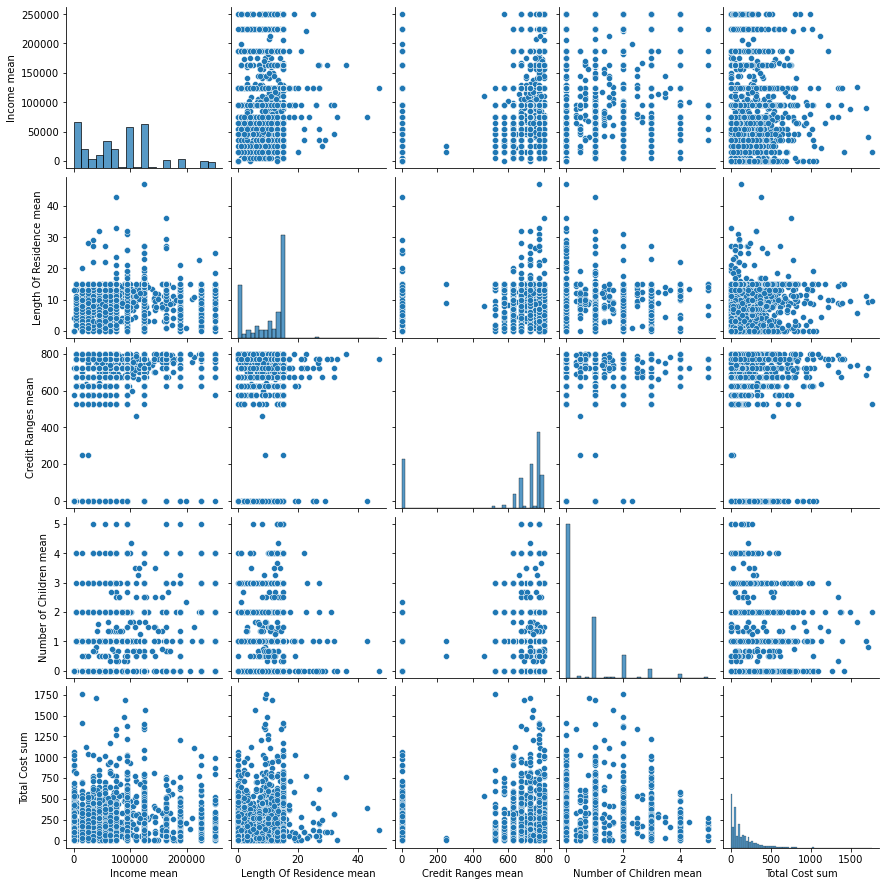

In [38]:
# Observation before filling NA
sns.pairplot(df_household[['Income mean', 'Length Of Residence mean',
                           'Credit Ranges mean', 'Number of Children mean', 'Total Cost sum']].fillna(0))
plt.show()

In [39]:
from sklearn.impute import SimpleImputer

In [40]:
numeric_features = df_household.select_dtypes(include=['float64', 'int64']).columns
imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
df_num = pd.DataFrame(imp_med.fit_transform(df_household[numeric_features]))
df_num.columns = numeric_features
df_num.index = df_household.index
df_num.head()

,Length Of Residence mean,Do Not Direct Mail Solicit mean,Email Available mean,ERS ENT Count Year 1 sum,ERS ENT Count Year 1 mean,ERS ENT Count Year 2 sum,ERS ENT Count Year 2 mean,ERS ENT Count Year 3 sum,ERS ENT Count Year 3 mean,ERS Member Cost Year 1 sum,...,Cost 2016 sum,Cost 2017 sum,Cost 2018 sum,Cost 2019 sum,Total Cost sum,Number of Children mean,Income mean,Credit Ranges mean,AssociateMember sum,PrimaryMember sum
Household Key,,,,,,,,,,,,,,,,,,,,,
875.0,14.000000,0.0,0.500000,2.0,0.500000,1.0,0.250000,4.0,1.00,117.70,...,230.0,26.50,58.85,58.85,1063.20,0.000000,95000.000000,775.000000,3.0,1.0
969.0,14.000000,0.0,0.750000,0.0,0.000000,2.0,0.500000,3.0,0.75,0.00,...,0.0,109.25,0.00,58.85,226.10,0.000000,95000.000000,800.000000,3.0,1.0
8718.0,15.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.000000,55000.000000,800.000000,0.0,1.0
11524.0,13.333333,0.0,1.000000,1.0,0.333333,5.0,1.666667,3.0,1.00,58.85,...,0.0,0.00,176.55,117.70,294.25,0.666667,138333.333333,741.666667,2.0,1.0
13422.0,15.000000,0.0,0.333333,1.0,0.333333,0.0,0.000000,0.0,0.00,58.85,...,0.0,0.00,0.00,58.85,118.85,0.000000,95000.000000,675.000000,2.0,1.0


#### One Hot Encoding

In [42]:
from sklearn.preprocessing import OneHotEncoder

In [43]:
categorical_features = df_household.select_dtypes(include=['category', 'object']).columns
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_household[categorical_features])
df_cat = pd.DataFrame(enc.transform(df_household[categorical_features]).toarray())
df_cat.columns = enc.get_feature_names()
df_cat.index = df_household.index
df_cat.head()

OneHotEncoder(handle_unknown='ignore')

,x0_1746.0,x0_1867.0,x0_1905.0,x0_2769.0,x0_2802.0,x0_2804.0,x0_2806.0,x0_2807.0,x0_2809.0,x0_2812.0,...,x10_N,x10_Y,x11_N,x11_Y,x12_N,x12_Y,x13_N,x13_Y,x14_N,x14_Y
Household Key,,,,,,,,,,,,,,,,,,,,,
875.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
969.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
8718.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
11524.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
13422.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


### Final Dataset

In [48]:
X = df_num.join(df_cat).join(df_household_product)
X.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3511 entries, 875.0 to 100079136.0
Columns: 252 entries, Length Of Residence mean to New Mover Flag
dtypes: float64(243), object(9)
memory usage: 6.9+ MB


In [49]:
X.head()

,Length Of Residence mean,Do Not Direct Mail Solicit mean,Email Available mean,ERS ENT Count Year 1 sum,ERS ENT Count Year 1 mean,ERS ENT Count Year 2 sum,ERS ENT Count Year 2 mean,ERS ENT Count Year 3 sum,ERS ENT Count Year 3 mean,ERS Member Cost Year 1 sum,...,x14_Y,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag
Household Key,,,,,,,,,,,,,,,,,,,,,
875.0,14.000000,0.0,0.500000,2.0,0.500000,1.0,0.250000,4.0,1.00,117.70,...,1.0,N,Y,N,N,N,N,N,N,Y
969.0,14.000000,0.0,0.750000,0.0,0.000000,2.0,0.500000,3.0,0.75,0.00,...,0.0,N,N,N,N,N,N,Y,N,N
8718.0,15.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,...,0.0,N,N,N,N,N,N,N,Y,N
11524.0,13.333333,0.0,1.000000,1.0,0.333333,5.0,1.666667,3.0,1.00,58.85,...,0.0,N,N,N,N,N,N,N,Y,N
13422.0,15.000000,0.0,0.333333,1.0,0.333333,0.0,0.000000,0.0,0.00,58.85,...,0.0,N,N,N,N,N,N,Y,Y,N


In [46]:
# Save data
X.to_csv('./data/processed_data.csv')